## Exercises for evaluating gluonic path integrals

Boadly, design a computer code for evaluating gluonic path integrals using the Metropolis algorithm.

In [1]:
begin
    using DelimitedFiles
    using Distributions: Uniform
    using SpecialFunctions
    using LaTeXStrings
    using LinearAlgebra
    using Match
    using Plots
    using Random
    using Test 
end

In [2]:
begin
    using BenchmarkTools
end

In [3]:
const N_DIMS = 4;

In [4]:
"""
    Params{T<:AbstractFloat,Q<:Integer}

Hold parameters for Monte Carlo Gluonic Integration

# Arguments
- `β::T`: ``\\tilde{β}/u_0^4`` (for the unimproved Wilson action)
- `ϵ::T`: Monte Carlo spacing
- `lattice_dimension::Q`: temporal + spacial dimensions (usually 4)
- `side_length`: L/a points on a side of the lattice; assumed isotropic hypercubic 
- `matrix_dimension`: SU(N='matrix_dimension') gauge theory
- `number_matrices`: Number of random matrices to draw from when updating (includes inverses)
- `N_cor`: Number of steps to update between measurements to reduce autocorrelation
- `N_cf`: Number of configurations to sample
- `N_hits`: Number of "hits" for each link
"""
struct Params{T<:AbstractFloat,Q<:Integer}
    a::T # Lattice spacing. May not actually be used; TODO check
    β::T
    u0::T
    ϵ::T
    lattice_dimension::Q
	side_length::Q
    matrix_dimension::Q
    number_matrices::Q
	N_cor::Q
	N_cf::Q
    N_hits::Q
end

Params

This is not longer used, it's kinda cool so I'll keep it for now.

In [6]:
"""
    braid(a,b)

Return the braid of 'a = [a₁,a₂,…]' and 'b = [b₁,b₂,…]' as [a₁,b₁,a₂,b₂,…].

# Example
```jldoctest
julia> a = [1,3,5]
julia> b = [2,4,6]
julia> braid(a,b)
6-element Vector{Int64}
1
2
3
4
5
6
```
"""
function braid(a,b)
    return collect(Iterators.flatten(zip(a,b)))
end

braid

In [7]:
@testset "braid tests" begin
    a = ones(10)
    b = zeros(10)
    braided = braid(a,b)
    ab = []
    for (ath,bth) in zip(a,b)
        push!(ab,ath)
        push!(ab,bth)
    end
    @test isequal(braided,ab)
    a = []
    b = []
    braided = braid(a,b)
    ab = []
    for (ath,bth) in zip(a,b)
        push!(ab,ath)
        push!(ab,bth)
    end
    @test isequal(braided,ab)
end

Test Summary: | Pass  Total
braid tests   |    2      2


Test.DefaultTestSet("braid tests", Any[], 2, false, false)

In [5]:
"""
    nearestneighbors(index, L)

Compute and return the 2*length(index) nearest neighbors (as a vector of 
    CartesianIndices) of the point 'index' in an 'L'^length(index) isotropic 
    hypercubic lattice.

# Example
```jldoctest
julia> nearestneighbors(CartesianIndex{2}(1,1),3)
4-element Vector{CartesianIndex{2}}:
CartesianIndex(2, 1)
CartesianIndex(1, 2)
CartesianIndex(3, 1)
CartesianIndex(1, 3)
```
"""
function nearestneighbors(index::CartesianIndex,L::Integer)
    dim = length(index)
    indicesplus = Vector{typeof(index)}(undef,dim)
    indicesminus = Vector{typeof(index)}(undef,dim)
    for n in eachindex(indicesplus)
        # temporary vector of original index to do cacluations on
        plus = collect(Tuple(index))
        minus = collect(Tuple(index))
        # Next and previous index for current dimension
        plus[n] = mod1(plus[n]+1,L)
        minus[n] = mod1(minus[n]-1,L)
        indicesplus[n] = typeof(index)(plus...)
        indicesminus[n] = typeof(index)(minus...)
    end
    #new(braid(indicesplus,indicesminus))
    return vcat(indicesplus,indicesminus)
end

nearestneighbors

In [9]:
"Messing around for less allocs"
function nearestneighbors!(indices, L)
    dim = length(indices)÷2
    for k in 1:dim 
        indices[k][k] = mod1(indices[k][k]+1,L)
        indices[k+dim][k] = mod1(indices[k+dim][k]-1,L)
    end
    return nothing
end

nearestneighbors!

In [6]:
@testset "Nearest Neighbors tests" begin	
	firstindex = CartesianIndex{N_DIMS}(1,1,1,1)
	@test isequal(nearestneighbors(firstindex,3), [
		CartesianIndex{N_DIMS}(2,1,1,1),
		CartesianIndex{N_DIMS}(1,2,1,1),
		CartesianIndex{N_DIMS}(1,1,2,1),
		CartesianIndex{N_DIMS}(1,1,1,2),
		CartesianIndex{N_DIMS}(3,1,1,1),
		CartesianIndex{N_DIMS}(1,3,1,1),
		CartesianIndex{N_DIMS}(1,1,3,1),
		CartesianIndex{N_DIMS}(1,1,1,3)
	])
	lastindex = CartesianIndex{N_DIMS}(3,3,3,3)
	@test isequal(nearestneighbors(lastindex,3), [
		CartesianIndex{N_DIMS}(1,3,3,3),
		CartesianIndex{N_DIMS}(3,1,3,3),
		CartesianIndex{N_DIMS}(3,3,1,3),
		CartesianIndex{N_DIMS}(3,3,3,1),
		CartesianIndex{N_DIMS}(2,3,3,3),
		CartesianIndex{N_DIMS}(3,2,3,3),
		CartesianIndex{N_DIMS}(3,3,2,3),
		CartesianIndex{N_DIMS}(3,3,3,2)
	])
	middleindex = CartesianIndex{N_DIMS}(2,2,2,2)
	@test isequal(nearestneighbors(middleindex,3), [
		CartesianIndex{N_DIMS}(3,2,2,2),
		CartesianIndex{N_DIMS}(2,3,2,2),
		CartesianIndex{N_DIMS}(2,2,3,2),
		CartesianIndex{N_DIMS}(2,2,2,3),
		CartesianIndex{N_DIMS}(1,2,2,2),
		CartesianIndex{N_DIMS}(2,1,2,2),
		CartesianIndex{N_DIMS}(2,2,1,2),
		CartesianIndex{N_DIMS}(2,2,2,1)
	])
	mixedindex = CartesianIndex{N_DIMS}(1,2,3,2)
	@test isequal(nearestneighbors(mixedindex,3), [
		CartesianIndex{N_DIMS}(2,2,3,2),
		CartesianIndex{N_DIMS}(1,3,3,2),
		CartesianIndex{N_DIMS}(1,2,1,2),
		CartesianIndex{N_DIMS}(1,2,3,3),
		CartesianIndex{N_DIMS}(3,2,3,2),
		CartesianIndex{N_DIMS}(1,1,3,2),
		CartesianIndex{N_DIMS}(1,2,2,2),
		CartesianIndex{N_DIMS}(1,2,3,1)
	])
	# Dimension generality removed from global constant dependancy
	firstindex = CartesianIndex{2}(1,1)
	@test isequal(nearestneighbors(firstindex,3), [
		CartesianIndex{2}(2,1),
		CartesianIndex{2}(1,2),
		CartesianIndex{2}(3,1),
		CartesianIndex{2}(1,3)
	])
end

Test Summary:           | Pass  Total
Nearest Neighbors tests |    5      5


Test.DefaultTestSet("Nearest Neighbors tests", Any[], 5, false, false)

In [7]:
"""
	Lattice{T<:CartesianIndex,U<:AbstractMatrix}

Hold nearest-neighbors look-up table and links for a lattice.

# Fields
- `nearestneighbors::Array{Vector{T}}`: An L^lat_dim array of 2*lat_dim Vectors 
	of CartesianIndex{lat_dim} for each of the neighboring points of each vertex. 
- `links::Array{Vector{U}}`: An L^lattice_dimension array of lat_dim Vectors 
	of Matrices for each of the links, represented as the links from each vertex
		noting that only positive directions are independent variables.
- `directions::UnitRange{Integer}`: Pre-allocation of directions used in some functions.

# Constructor Arguments
- `N_lat::Integer`: Temporal + spacial dimensions of lattice (usually four)
- `N::Integer`: SU(N) for the lattice links
- `L::Integer`: ``L/a`` points on a side of the lattice; assumed isotropic hypercubic 
"""
struct Lattice{T<:CartesianIndex,U<:AbstractMatrix}
    nearest_neighbors::Array{Vector{T}}
	links::Array{Vector{U}}
	directions::UnitRange{Integer}
	
	function Lattice(N_lat::Integer, N::Integer, L::Integer)
		directions = 1:N_lat

		nearest_neighbors = Array{Vector{CartesianIndex{N_lat}},N_lat}(undef,fill(L,N_lat)...)
		links = Array{Vector{Matrix{ComplexF64}},N_lat}(undef,fill(L,N_lat)...)

		for index in CartesianIndices(nearest_neighbors)
			nearest_neighbors[index] = nearestneighbors(index,L)
			links[index] = [Matrix{ComplexF64}(I,N,N) for _ in 1:N_lat]
			#for direction in directions
			#links[index] = fill(Matrix{ComplexF64}(I,N,N),N_lat)
			#links[index][direction] = Matrix{ComplexF64}(I,N,N)
			#end
		end

        return new{CartesianIndex{N_lat},Matrix{ComplexF64}}(nearest_neighbors,
			links,directions)
	end
end

Lattice

In [8]:
@testset "Lattice tests" begin
    L = 3
    lattice = Lattice(4,3,L)
    # Test that each neighbor is correctly created
    for t in 1:L, x in 1:L, y in 1:L, z in 1:L
        nrstnghbrs = [ 
            CartesianIndex(mod1(t+1,L),x,y,z),
            CartesianIndex(t,mod1(x+1,L),y,z),
            CartesianIndex(t,x,mod1(y+1,L),z),
            CartesianIndex(t,x,y,mod1(z+1,L)),
            CartesianIndex(mod1(t-1,L),x,y,z),
            CartesianIndex(t,mod1(x-1,L),y,z),
            CartesianIndex(t,x,mod1(y-1,L),z),
            CartesianIndex(t,x,y,mod1(z-1,L))
        ]
        #@test isequal(lattice.nearest_neighbors[t,x,y,z][:], Neighbors(CartesianIndex{N_DIMS}(t,x,y,z),L)[:])
        @test isequal(lattice.nearest_neighbors[t,x,y,z], nrstnghbrs)
    end
    # Check cold start
    for index in CartesianIndices(lattice.links)
        @test isequal(lattice.links[index], fill(Matrix{ComplexF64}(I,3,3),N_DIMS)) 
    end
end

Test Summary: | Pass  Total
Lattice tests |  162    162


Test.DefaultTestSet("Lattice tests", Any[], 162, false, false)

The unitarize(H) function unitarizes an arbitrary complex matrix H by QR factorization, made unique by some postprocessing, see [https://arxiv.org/abs/math-ph/0609050].

In [9]:
"""
    unitarize(M)

Return the unique¹ unitarization of a matrix 'M'.

¹See F. Mezzadri. "How to generate random matrices from the classical compact groups," 
	Notices of the AMS, Volume 54, Issue 5, pp. 592-604, 2007.

# Example
```jldoctest
julia> A = [12.0 -51.0 4.0; 6. 167.0 -68.0; -4.0 24.0 -41.0]
julia> unitarize(A)
3x3 Matrix{Float64}
  0.857143  -0.394286  -0.331429
  0.428571   0.902857   0.0342857
 -0.285714   0.171429  -0.942857
```
"""
function unitarize(H)#,ϵ)
	#A = I + ϵ*1im*H
	QR = qr(H)
	T = Diagonal(QR.R)
	T /= abs.(T)
	Q = QR.Q*T
	return Q/det(Q)^(1/size(Q,1))
end

unitarize

In [48]:
# Might get some good performance with special matrix types; TODO
function unitarizedeconstructed(A)
	#A = I + ϵ*1im*H
	QR = qr(A)
	diagR = Diagonal(QR.R)
	diagR /= abs.(diagR)
	return QR.Q,diagR
end

unitarize (generic function with 1 method)

In [10]:
# Lazy Gram-Schmidt and cross product for 3×3 matrices
function unitarizeSU3(H)
    m1 = H[:,1]
    m1 = m1/norm(m1)

    m2 = H[:,2] - dot(m1,H[:,2])*m1
    m2 = m2/norm(m2)

    m3 = conj(cross(m1,m2))
    return [m1 m2 m3]
end

unitarizeSU3 (generic function with 1 method)

In [11]:
@testset "unitarize tests" begin
    ϵ = 0.24
    for _ in 1:100 # This is probably not the right way to test something lol
        H = rand(Uniform(-1,1),3,3)
        U = unitarize(I+ϵ*1im*Hermitian(H))
        @test isapprox(U*U',I)
    end
    # Test the extreme possibilities that I can think of
    H = ones(3,3)
    U = unitarize(I+ϵ*1im*Hermitian(H))
    @test isapprox(U*U',I)
    H = -1*ones(3,3)
    U = unitarize(I+ϵ*1im*Hermitian(H))
    @test isapprox(U*U',I)
    H = zeros(3,3)
    U = unitarize(I+ϵ*1im*Hermitian(H))
    @test isapprox(U*U',I)

    # Wikipedia Example
    #A = [12.0 -51.0 4.0; 6. 167.0 -68.0; -4.0 24.0 -41.0]
    #Q = [-6/7 69/175 58/175; -3/7 -158/175 -6/175; 2/7 -6/35 33/35]
    #R = [-14.0 -21.0 14.0; 0.0 -175.0 70.0; 0.0 0.0 -35.0]
    #diagR = [-14.0 0.0 0.0; 0.0 -175.0 0.0; 0.0 0.0 -35.0]
    #diagR = [-1.0 0.0 0.0; 0.0 -1.0 0.0; 0.0 0.0 -1.0] #Kind of an unit
    #@test isapprox(Q*-1, unitarize(A))
end

Test Summary:   | Pass  Total
unitarize tests |  103    103


Test.DefaultTestSet("unitarize tests", Any[], 103, false, false)

In [12]:
@testset "unitarizeSU3 tests" begin
    ϵ = 0.24
    for _ in 1:100 # This is probably not the right way to test something lol
        H = rand(Uniform(-1,1),3,3)
        U = unitarizeSU3(I+ϵ*1im*Hermitian(H))
        @test isapprox(U*U',I)
    end
    # Test the extreme possibilities that I can think of
    H = ones(3,3)
    U = unitarizeSU3(I+ϵ*1im*Hermitian(H))
    @test isapprox(U*U',I)
    H = -1*ones(3,3)
    U = unitarizeSU3(I+ϵ*1im*Hermitian(H))
    @test isapprox(U*U',I)
    H = zeros(3,3)
    U = unitarizeSU3(I+ϵ*1im*Hermitian(H))
    @test isapprox(U*U',I)

    #H = rand(Uniform(-1,1),3,3)
    #@test isapprox(unitarizeSU3(I+ϵ*1im*H),unitarize(I+ϵ*1im*H))
end

Test Summary:      | Pass  Total
unitarizeSU3 tests |  103    103


Test.DefaultTestSet("unitarizeSU3 tests", Any[], 103, false, false)

In [13]:
"""
    generatematrices(N,number,ϵ)

Return a vector of 'number' random unitary matrices.

These should approximately span SU('N'), with an 'ϵ' Monte Carlo spacing
    controlling how from from unit they are. For any element of the array, its
    inverse is also included, so there are 'number'/2 independent variables.

# Example
```jldoctest
julia> Random.seed!(1234)
julia> generatematrices(1,2,0.24)
2-element Vector{Matrix{ComplexF64}}:
 [0.9990506370356733 + 0.04356402918252162im]
 [0.9990506370356733 - 0.04356402918252162im]
```
"""
function generatematrices(N,number,ϵ)
    matrices = Vector{Matrix{Complex{Float64}}}(undef,number)

    for j in 1:2:number # Half the elements are just inverses
        H = Hermitian(rand(Uniform(-1,1),N,N)) # Generate random NxN hermitean matrix
        U = unitarize(I+ϵ*1im*H) # Unitarize 1 + iϵH
        matrices[j] = U
        matrices[j+1] = U'
    end

    return matrices
end

generatematrices

In [14]:
@testset "generatematrices Tests" begin
    #Random.seed!(1234)
    matrices = generatematrices(3,50,0.24)
    for U in matrices
        @test U*U' ≈ I # Check that each random matrix is unitary
        @test U' in matrices # Check that the inverse is included
        @test det(U) ≈ 1 # Check each is in SU
    end
end

Test Summary:          | Pass  Total
generatematrices Tests |  150    150


Test.DefaultTestSet("generatematrices Tests", Any[], 150, false, false)

### Plaquettes

The shortest, nontrivial closed loop on the lattice is the plaquette, given by 
Eq. (88) in the notes:

$$
\begin{align*}
    P_{\mu\nu}(x) &= \frac{1}{3}\Re\mathop{\text{tr}}(U_{\mu}(x)U_{\nu}(x+\hat{\mu})U_{-\mu}(x+\hat{\mu}+\hat{\nu})U_{-\nu}(x+\hat{\nu}))\\
        &=  \frac{1}{3}\Re\mathop{\text{tr}}(U_{\mu}(x)U_{\nu}(x+\hat{\mu})U_{\mu}^{\dagger}(x+\hat{\nu})U_{\nu}^{\dagger}(x)).
\end{align*}
$$

In [17]:
"""
    plaquetteoperator(lattice, x, μ, ν)

Return the plaquette operator, 
    ``P_{μν}(x) ≔ \\frac{1}{3}\\Re\\tr(U_{μ}(x)U_{ν}(x+))``
from the vertex 'x' of 'lattice' in the 'μ''ν'-plane.

# Example
```jldoctest
julia> lattice = Lattice(4,3,8);
julia> x = CartesianIndex{4}(1,1,1,1);
julia> μ = 1; ν = 2;
julia> plaquetteoperator(lattice, x, μ, ν)
1.0
```
"""
function plaquetteoperator(lattice::Lattice, x::CartesianIndex, μ::Integer, 
        ν::Integer)
    # Get neighboring sites in the positive μ and ν directions
    xplusμ = lattice.nearest_neighbors[x][μ]
    xplusν = lattice.nearest_neighbors[x][ν]

    return real(tr(lattice.links[x][μ]*lattice.links[xplusμ][ν]
        *lattice.links[xplusν][μ]'*lattice.links[x][ν]'))/3
end

plaquetteoperator

A common operation throughout the code is taking the trace of the product of some number of matrices. Since there is no built-in function that performs this in place, just calling the operations for $k$ multiplications will result in $k-1$ allocations of intermediate matrices, which is unnecessary as taking the trace just results in an additional summation. That is,

$$
    \mathop{\text{tr}}(A_1 A_2\dots A_k) = (A_1)_{j_{1}j_{2}}(A_2)_{j_{2}j_{3}}\dots(A_k)_{j_{k-1}j_{k}}.
$$

In particular, we will be taking traces of the products of three and four matrices, which we can simply (if naively) implement as follows:

Note: This only seems faster for small matrices, which is still useful. It scales very poorly even at $10\times10$.

In [15]:
"""
    trmul(A,B,C,D)

Return tr(A⋅B⋅C⋅D), where 'A', 'B', 'C', and 'D' are assumed to be square 
matrices of the same dimensions and eltypes.

# Examples
```jldoctest
julia> A = [1 2 3; 4 5 6; 7 8 9];
julia> B = A*2; C = A*3; D = A*4
julia> trmul(A,B,C,D)
1619352
julia> trmul(A,B,C',D')
1748952
```
"""
function trmul(A, B, C, D)
    # Just assume typeof(A) == typeof(B) etc, can change later if ever needed.
    #@boundscheck size(A) == size(B) && size(A) == size(C) && size(A) == size(D) || throw(BoundsError())
    #out = zero(promote_type(eltype(A),eltype(B),eltype(C),eltype(D)))
    out = zero(eltype(A))
    @inbounds for j in 1:size(A,1), i in 1:size(A,1), k in 1:size(A,1), m in 1:size(A,1) 
        out += A[j,i]*B[i,k]*C[k,m]*D[m,j]
    end
    return out
end

"""
    trmul(A,B,C)

Return tr(A⋅B⋅C), where 'A', 'B', and 'C' are assumed to be square 
matrices of the same dimensions and eltypes.

# Examples
```jldoctest
julia> A = [1 2 3; 4 5 6; 7 8 9];
julia> B = A*2; C = A*3;
julia> trmul(A,B,C)
TODO
julia> trmul(A,B,C')
TODO
```
"""
function trmul(A, B, C)
    # Just assume typeof(A) == typeof(B) etc, can change later if ever needed.
    #@boundscheck size(A) == size(B) && size(A) == size(C) && size(A) == size(D) || throw(BoundsError())
    #out = zero(promote_type(eltype(A),eltype(B),eltype(C),eltype(D)))
    out = zero(eltype(A))
    @inbounds for j in 1:size(A,1), i in 1:size(A,1), k in 1:size(A,1) 
        out += A[j,i]*B[i,k]*C[k,j]
    end
    return out
end
function trmul(A, B, C, D, E, F)
    # Just assume typeof(A) == typeof(B) etc, can change later if ever needed.
    #@boundscheck size(A) == size(B) && size(A) == size(C) && size(A) == size(D) || throw(BoundsError())
    #out = zero(promote_type(eltype(A),eltype(B),eltype(C),eltype(D)))
    out = zero(eltype(A))
    @inbounds for j in 1:size(A,1), i in 1:size(A,1), k in 1:size(A,1), m in 1:size(A,1), n in 1:size(A,1), l in 1:size(A,1) 
        out += A[j,i]*B[i,k]*C[k,m]*D[m,n]*E[n,l]*F[l,j]
    end
    return out
end

trmul (generic function with 3 methods)

In [50]:
function trmulnaive(A,B,C)
    return tr(A*B*C)
end

trmulnaive (generic function with 1 method)

In [ ]:
function trmulnoloop(A,B,C)
    
end

In [52]:
function test()
    Random.seed!(1234)
    A = I + 0.24im*rand(3,3)
    B = I + 0.24im*rand(3,3)
    C = I + 0.24im*rand(3,3)
    @benchmark trmul($A,$B,$C)
end
test()

BenchmarkTools.Trial: 10000 samples with 991 evaluations.
 Range (min … max):  39.556 ns … 194.854 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     39.657 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   41.840 ns ±   8.783 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █       ▃▃▁                                                  ▁
  █▇▅▄▅▄▄▇████▇▆▆▆▆▅▄▅▄▅▅▅▅▄▄▁▁▄▃▄▄▅▅▆▆▆▆▇▇▇▆▅▄▆▄▅▆▅▅▄▆▄▅▄▃▁▄▄ █
  39.6 ns       Histogram: log(frequency) by time      83.5 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [53]:
function test()
    Random.seed!(1234)
    A = I + 0.24im*rand(3,3)
    B = I + 0.24im*rand(3,3)
    C = I + 0.24im*rand(3,3)
    @benchmark trmulnaive($A,$B,$C)
end
test()

BenchmarkTools.Trial: 10000 samples with 942 evaluations.
 Range (min … max):  105.414 ns …   3.286 μs  ┊ GC (min … max):  0.00% … 92.52%
 Time  (median):     114.650 ns               ┊ GC (median):     0.00%
 Time  (mean ± σ):   139.196 ns ± 169.424 ns  ┊ GC (mean ± σ):  11.26% ±  8.83%

  █▇▇▇▆▅▄▃▂▂▂▂▁▁▁                                               ▂
  █████████████████▇█▇█████▇▇▇▇▆▆▆▆▅▂▅▅▅▄▄▅▅▆▅▅▅▅▆▅▄▅▆▄▄▅▄▂▅▄▃▄ █
  105 ns        Histogram: log(frequency) by time        328 ns <

 Memory estimate: 448 bytes, allocs estimate: 2.

In [16]:
@testset "trmul tests" begin
    Random.seed!(1234)
    A = rand(10,10)
    B = rand(10,10)
    C = rand(10,10)
    D = rand(10,10)

    @test trmul(A,B,C) ≈ tr(A*B*C)

    @test trmul(A,B,C,D) ≈ tr(A*B*C*D)
end

Test Summary: | Pass  Total
trmul tests   |    2      2


Test.DefaultTestSet("trmul tests", Any[], 2, false, false)

In [17]:
function plaquetteoperator(lattice::Lattice, x::CartesianIndex, μ::Integer, 
    ν::Integer)
# Get neighboring sites in the positive μ and ν directions
xplusμ = lattice.nearest_neighbors[x][μ]
xplusν = lattice.nearest_neighbors[x][ν]

return real(trmul( lattice.links[x][μ],lattice.links[xplusμ][ν],lattice.links[xplusν][μ]',lattice.links[x][ν]' ))/3
end

plaquetteoperator (generic function with 1 method)

In [18]:
@testset "plaquetteoperator tests" begin
    LAT_DIM = 2
    MAT_DIM = 3
    L = 3
    lattice = Lattice(LAT_DIM,MAT_DIM,L)
    f(x) = isodd(x) ? 5 : 7
    for (j,index) in enumerate(CartesianIndices(lattice.links))
        for (k,directionindex) in enumerate(eachindex(lattice.links[index]))
            lattice.links[index][directionindex] += (j+f(k)*1im)*Matrix{ComplexF64}(I,3,3)
        end
    end
    
    μ=1
    ν=2
    @test plaquetteoperator(lattice,CartesianIndex{LAT_DIM}(1,1),μ,ν) == real((2+5im)*(3+7im)*conj(5+5im)*conj(2+7im))
    @test plaquetteoperator(lattice,CartesianIndex{LAT_DIM}(2,1),μ,ν) == real((3+5im)*(4+7im)*conj(6+5im)*conj(3+7im))
    @test plaquetteoperator(lattice,CartesianIndex{LAT_DIM}(3,1),μ,ν) == real((4+5im)*(2+7im)*conj(7+5im)*conj(4+7im))
    @test plaquetteoperator(lattice,CartesianIndex{LAT_DIM}(1,2),μ,ν) == real((5+5im)*(6+7im)*conj(8+5im)*conj(5+7im))
    @test plaquetteoperator(lattice,CartesianIndex{LAT_DIM}(2,2),μ,ν) == real((6+5im)*(7+7im)*conj(9+5im)*conj(6+7im))
    @test plaquetteoperator(lattice,CartesianIndex{LAT_DIM}(3,2),μ,ν) == real((7+5im)*(5+7im)*conj(10+5im)*conj(7+7im))
    @test plaquetteoperator(lattice,CartesianIndex{LAT_DIM}(1,3),μ,ν) == real((8+5im)*(9+7im)*conj(2+5im)*conj(8+7im))
    @test plaquetteoperator(lattice,CartesianIndex{LAT_DIM}(2,3),μ,ν) == real((9+5im)*(10+7im)*conj(3+5im)*conj(9+7im))
    @test plaquetteoperator(lattice,CartesianIndex{LAT_DIM}(3,3),μ,ν) == real((10+5im)*(8+7im)*conj(4+5im)*conj(10+7im))

    μ=2
    ν=1
    @test plaquetteoperator(lattice,CartesianIndex{LAT_DIM}(1,1),μ,ν) == real(conj(2+5im)*conj(3+7im)*(5+5im)*(2+7im))
    @test plaquetteoperator(lattice,CartesianIndex{LAT_DIM}(2,1),μ,ν) == real(conj(3+5im)*conj(4+7im)*(6+5im)*(3+7im))
    @test plaquetteoperator(lattice,CartesianIndex{LAT_DIM}(3,1),μ,ν) == real(conj(4+5im)*conj(2+7im)*(7+5im)*(4+7im))
    @test plaquetteoperator(lattice,CartesianIndex{LAT_DIM}(1,2),μ,ν) == real(conj(5+5im)*conj(6+7im)*(8+5im)*(5+7im))
    @test plaquetteoperator(lattice,CartesianIndex{LAT_DIM}(2,2),μ,ν) == real(conj(6+5im)*conj(7+7im)*(9+5im)*(6+7im))
    @test plaquetteoperator(lattice,CartesianIndex{LAT_DIM}(3,2),μ,ν) == real(conj(7+5im)*conj(5+7im)*(10+5im)*(7+7im))
    @test plaquetteoperator(lattice,CartesianIndex{LAT_DIM}(1,3),μ,ν) == real(conj(8+5im)*conj(9+7im)*(2+5im)*(8+7im))
    @test plaquetteoperator(lattice,CartesianIndex{LAT_DIM}(2,3),μ,ν) == real(conj(9+5im)*conj(10+7im)*(3+5im)*(9+7im))
    @test plaquetteoperator(lattice,CartesianIndex{LAT_DIM}(3,3),μ,ν) == real(conj(10+5im)*conj(8+7im)*(4+5im)*(10+7im))
end

Test Summary:           | Pass  Total
plaquetteoperator tests |   18     18


Test.DefaultTestSet("plaquetteoperator tests", Any[], 18, false, false)

In [19]:
"""
    rectangleoperator(lattice, x, μ, ν)

Return the a×2a rectangle operator, 
from the vertex 'x' of 'lattice' in the 'μ''ν'-plane.

# Example
```jldoctest
julia> lattice = Lattice(4,3,8);
julia> x = CartesianIndex{4}(1,1,1,1);
julia> μ = 1; ν = 2;
julia> rectangleoperator(lattice, x, μ, ν)
TODO
```
"""
#    ``R_{μν} ≔ \\Re\\mathop{\\text{tr}}( U_{ν}(x)U_{μ}(x+\\hat{ν})U_{μ}(x+\\hat{ν}+\hat{μ})U_{ν}^†(x+2\\hat{μ})U_{μ}^†(x+\\hat{μ})U_{μ}^†(x) ) ``

function rectangleoperator(lattice::Lattice, x::CartesianIndex, μ::Integer, 
    ν::Integer)
# Get neighboring sites in the positive μ and ν directions
xplusμ = lattice.nearest_neighbors[x][μ]
xplusν = lattice.nearest_neighbors[x][ν]
xplusνplusμ = lattice.nearest_neighbors[xplusν][μ]
xplus2μ = lattice.nearest_neighbors[xplusμ][μ]

return real(tr(lattice.links[x][ν]*lattice.links[xplusν][μ]*
        lattice.links[xplusνplusμ][μ]*lattice.links[xplus2μ][ν]'*
        lattice.links[xplusμ][μ]'*lattice.links[x][μ]'
    ))/3
end


rectangleoperator (generic function with 1 method)

In [20]:
"""
    plaquetteoperator(lattice, x, μ, ν)

Return the plaquette operator, 
    ``P_{μν}(x) ≔ \\frac{1}{3}\\Re\\tr(U_{μ}(x)U_{ν}(x+))``
from the vertex 'x' of 'lattice' in the 'μ''ν'-plane.

# Example
```jldoctest
julia> lattice = Lattice(4,3,8);
julia> x = CartesianIndex{4}(1,1,1,1);
julia> μ = 1; ν = 2;
julia> plaquetteoperator(lattice, x, μ, ν)
1.0
```
"""
function measureplaquette(lattice::Lattice)
    sum = 0.0
    for x in CartesianIndices(lattice.links)
        for μ in lattice.directions
            for ν in 1:μ-1
                sum += plaquetteoperator(lattice,x,μ,ν)
            end
        end
    end
    return sum
end

measureplaquette

In [21]:
function measurerectangle(lattice::Lattice)
    sum = 0.0
    for x in CartesianIndices(lattice.links)
        for μ in lattice.directions
            for ν in 1:μ-1
                sum += rectangleoperator(lattice,x,μ,ν)
            end
        end
    end
    return sum
end

measurerectangle (generic function with 1 method)

In [22]:
@testset "plaquette average tests" begin
    LAT_DIM = 2
    MAT_DIM = 3
    L = 3
    lattice = Lattice(LAT_DIM,MAT_DIM,L)
    f(x) = isodd(x) ? 5 : 7
    for (j,index) in enumerate(CartesianIndices(lattice.links))
        for (k,directionindex) in enumerate(eachindex(lattice.links[index]))
            lattice.links[index][directionindex] += (j+f(k)*1im)*Matrix{ComplexF64}(I,3,3)
        end
    end

    average = (real((2+5im)*(3+7im)*conj(5+5im)*conj(2+7im))
        + real((3+5im)*(4+7im)*conj(6+5im)*conj(3+7im))
        + real((4+5im)*(2+7im)*conj(7+5im)*conj(4+7im))
        + real((5+5im)*(6+7im)*conj(8+5im)*conj(5+7im))
        + real((6+5im)*(7+7im)*conj(9+5im)*conj(6+7im))
        + real((7+5im)*(5+7im)*conj(10+5im)*conj(7+7im))
        + real((8+5im)*(9+7im)*conj(2+5im)*conj(8+7im))
        + real((9+5im)*(10+7im)*conj(3+5im)*conj(9+7im))
        + real((10+5im)*(8+7im)*conj(4+5im)*conj(10+7im)))
    @test measureplaquette(lattice) == average
end

Test Summary:           | Pass  Total
plaquette average tests |    1      1


Test.DefaultTestSet("plaquette average tests", Any[], 1, false, false)

### Local action and staples

When updating the a particular link, $U_\mu(x)$, we need to determine what local part of the action that needs to be computed, to deterime the change in said action. Let us look at some $\mu\nu$-plane:

<center><img src="images/plaquettestaples2.png" width=600 height=500/></center>

We can observe that within this plane, there are two distinct plaquettes that involve the link $U_\mu(x)$ (or its hermitean conjugate). That is, for any given plane, the piece of the action depending on some link is 

$$ S_{\mu\nu}(x) = \Re \mathop{\text{tr}} ( U_{\mu}(x)U_{\nu}(x+\hat{\mu})U_{\mu}^\dagger(x+\hat{\nu})U_{\nu}^\dagger(x) + U_{\mu}(x-\hat{\nu})U_{\nu}(x+\hat{\mu}-\hat{\nu})U_{\mu}^\dagger(x)U_{\nu}^\dagger(x-\hat{\nu}) ). $$

Looking at the second term above, we can rewrite is as

$$ 
\begin{align*}
\Re \mathop{\text{tr}}U_{\mu}(x-\hat{\nu})U_{\nu}(x+\hat{\mu}-\hat{\nu})U_{\mu}^\dagger(x)U_{\nu}^\dagger(x-\hat{\nu}) &= \Re \mathop{\text{tr}}(U_{\nu}(x-\hat{\nu})U_{\mu}(x)U_{\nu}^\dagger(x+\hat{\mu}-\hat{\nu})U_{\mu}^\dagger(x-\hat{\nu}))^\dagger\\
    &= \Re \mathop{\text{tr}}(U_{\nu}(x-\hat{\nu})U_{\mu}(x)U_{\nu}^\dagger(x+\hat{\mu}-\hat{\nu})U_{\mu}^\dagger(x-\hat{\nu}))^{t*}\\
    &= \Re \mathop{\text{tr}}(U_{\nu}(x-\hat{\nu})U_{\mu}(x)U_{\nu}^\dagger(x+\hat{\mu}-\hat{\nu})U_{\mu}^\dagger(x-\hat{\nu}))^{*}\\
    &= \Re (\mathop{\text{tr}}U_{\nu}(x-\hat{\nu})U_{\mu}(x)U_{\nu}^\dagger(x+\hat{\mu}-\hat{\nu})U_{\mu}^\dagger(x-\hat{\nu}))^{*}\\
    &= \Re\mathop{\text{tr}}U_{\nu}(x-\hat{\nu})U_{\mu}(x)U_{\nu}^\dagger(x+\hat{\mu}-\hat{\nu})U_{\mu}^\dagger(x-\hat{\nu})\\
    &= \Re\mathop{\text{tr}}U_{\mu}(x)U_{\nu}^\dagger(x+\hat{\mu}-\hat{\nu})U_{\mu}^\dagger(x-\hat{\nu})U_{\nu}(x-\hat{\nu}),
\end{align*}
$$

where used that a matrix and its transpose have same trace, that the trace of the conjugate of a matrix is the conjugate of the trace of the matrix, that we are taking the real part of a number, and finally the cyclic invariance of the trace. Substituting back in, we have

$$ S_{\mu\nu}(x) = \Re \mathop{\text{tr}}U_\mu(x)( U_{\nu}(x+\hat{\mu})U_{\mu}^\dagger(x+\hat{\nu})U_{\nu}^\dagger(x) + U_{\nu}^\dagger(x+\hat{\mu}-\hat{\nu})U_{\mu}^\dagger(x-\hat{\nu})U_{\nu}(x-\hat{\nu})). $$

Therefore, we can sum over all planes (e.g., just the one for 2d, and three for 4d) to get the total local action for some $U_\mu(X)$ as 

$$ S_\mu(x) = \sum_{\nu!=\mu}S_{\mu\nu}(x) = \Re\mathop{\text{tr}} U_\mu(x)\Gamma_\mu(x),\tag{1}$$

where 

$$ \Gamma_\mu(x) = \sum_{\nu!=\mu}U_{\nu}(x+\hat{\mu})U_{\mu}^\dagger(x+\hat{\nu})U_{\nu}^\dagger(x) + U_{\nu}^\dagger(x+\hat{\mu}-\hat{\nu})U_{\mu}^\dagger(x-\hat{\nu})U_{\nu}(x-\hat{\nu})$$

is the sum over all staples, and so is not affected by the change of $U_\mu(x)$.

In [26]:
function allstaples(lattice,x,μ)
    νs = filter(ν -> ν != μ, 1:length(x))

    xpμ = lattice.nearest_neighbors[x][μ] # Doesn't change (only one)
    xpν = zero(xpμ)
    xmν = zero(xpμ)
    xpμmν = zero(xpμ)

    Γ = zero(lattice.links[x][μ])

    for ν in νs 
        xpν = lattice.nearest_neighbors[x][ν]
        xmν = lattice.nearest_neighbors[x][ν+length(x)]
        xpμmν = lattice.nearest_neighbors[xpμ][ν+length(x)]

        Γ += (lattice.links[xpμ][ν]*lattice.links[xpν][μ]'*lattice.links[x][ν]'
            + lattice.links[xpμmν][ν]'*lattice.links[xmν][μ]'*lattice.links[xmν][ν])
    end

    return Γ
end

allstaples (generic function with 1 method)

We can get almost a 40% increase in speed by taking advantage of the five argument, in-place matrix multiplication subroutine in Julia (cf. LAPACK). Instead of calculating

$$ \Gamma_\mu(x) = \sum_{\nu!=\mu}U_{\nu}(x+\hat{\mu})U_{\mu}^\dagger(x+\hat{\nu})U_{\nu}^\dagger(x) + U_{\nu}^\dagger(x+\hat{\mu}-\hat{\nu})U_{\mu}^\dagger(x-\hat{\nu})U_{\nu}(x-\hat{\nu}),$$



In [23]:
function plaquettestaples(lattice,x,μ)
    νs = filter(ν -> ν != μ, 1:length(x))

    xpμ = lattice.nearest_neighbors[x][μ] # Doesn't change (only one)
    xpν = zero(xpμ)
    xmν = zero(xpμ)
    xpμmν = zero(xpμ)

    Γ = zero(lattice.links[x][μ])
    temp = similar(Γ)
    for ν in νs 
        xpν = lattice.nearest_neighbors[x][ν]
        xmν = lattice.nearest_neighbors[x][ν+length(x)]
        xpμmν = lattice.nearest_neighbors[xpμ][ν+length(x)]

        mul!(temp,lattice.links[x][ν],lattice.links[xpν][μ])

        mul!(Γ, lattice.links[xpμ][ν], temp',1.0,1.0)

        mul!(temp,lattice.links[xmν][μ],lattice.links[xpμmν][ν])

        mul!(Γ,temp',lattice.links[xmν][ν],1.0,1.0)

        #Γ += (lattice.links[xpμ][ν]*lattice.links[xpν][μ]'*lattice.links[x][ν]'
        #    + lattice.links[xmν][ν]*lattice.links[xmν][μ]'*lattice.links[xpμmν][ν]')
    end

    return Γ
end 

plaquettestaples (generic function with 1 method)

<center><img src="images/allrectanglestaples.png" width=600 height=500/></center>


### Improved local action staples

<center><img src="images/allrectanglestaples.png" width=600 height=500/></center>


The improved action, Eq. (103)

$$
    S_\text{improved} = -\beta\sum_{x,\mu>\nu}( \frac{5}{3}\frac{P_{\mu\nu}}{u_0^4} - \frac{R_{\mu\nu}+R_{\nu\mu}}{12u_0^6} )
$$

has the local action

$$ 
    S^\text{improved}_\mu(x) = -\beta( \frac{5}{3}\frac{S^{P}_\mu(x)}{u_0^4} - \frac{S^{R}_\mu(x)}{12u_0^6} ),
$$

where $S^P_x$ is the local action from the plaquette operators, i.e., the unimproved local action, and $S^R_x$ is the local action from the rectangle operators, which we shall now find. Looking at the $\mu\nu$-plane, we have local contributions from four $R_{\mu\nu}$ operators, in green and yellow, and two from $R_{\nu\mu}$ operators, in blue. Therefore, the local planar contribution from rectangle operators is

$$
\begin{align*}
    S^R_{\mu\nu}(x) &= \frac{1}{3}\Re\mathop{\text{tr}}( U_{\mu}(x)U_{\mu}(x+\hat{\mu})U_{\nu}(x+2\hat{\mu})U_{\mu}^{\dagger}(x+\hat{\mu}+\hat{\nu})U_{\mu}^{\dagger}(x+\hat{\nu})U_{\nu}^{\dagger}(x) ) + \frac{1}{3}\Re\mathop{\text{tr}}( U_{\mu}(x-\hat{\nu})U_{\mu}(x+\hat{\mu}-\hat{\nu})U_{\nu}(x+2\hat{\mu}-\hat{\nu})U_{\mu}^{\dagger}(x+\hat{\mu})U_{\mu}^{\dagger}(x)U_{\nu}^{\dagger}(x-\hat{\nu}) )\\
        &+ \frac{1}{3}\Re\mathop{\text{tr}}( U_{\mu}(x-\hat{\mu})U_{\mu}(x)U_{\nu}(x+\hat{\mu})U_{\mu}^{\dagger}(x+\hat{\nu})U_{\mu}^{\dagger}(x+\hat{\nu}-\hat{\mu})U_{\nu}^{\dagger}(x-\hat{\mu}) ) + \frac{1}{3}\Re\mathop{\text{tr}}( U_{\mu}(x-\hat{\nu}-\hat{\mu})U_{\mu}(x-\hat{\nu})U_{\nu}(x+\hat{\mu}-\hat{\nu})U_{\mu}^{\dagger}(x)U_{\mu}^{\dagger}(x-\hat{\mu})U_{\nu}^{\dagger}(x-\hat{\nu}-\hat{\mu}) )\\
        &+ \frac{1}{3}\Re\mathop{\text{tr}}( U_{\nu}(x-2\hat{\nu})U_{\nu}(x-\hat{\nu})U_{\mu}(x)U_{\nu}^{\dagger}(x+\hat{\mu}-\hat{\nu})U_{\nu}^{\dagger}(x+\hat{\mu}-2\hat{\nu})U_{\mu}^{\dagger}(x-2\hat{\nu}) ) + \frac{1}{3}\Re\mathop{\text{tr}}( U_{\nu}(x)U_{\nu}(x+\hat{\nu})U_{\mu}(x+2\hat{\nu})U_{\nu}^{\dagger}(x+\hat{\mu}+\hat{\nu})U_{\nu}^{\dagger}(x+\hat{\mu})U_{\mu}^{\dagger}(x) )
\end{align*}
$$

Ut supra, we can rewrite the second term as

$$
\begin{align*}
    \Re\mathop{\text{tr}}( U_{\mu}(x-\hat{\nu})U_{\mu}(x+\hat{\mu}-\hat{\nu})U_{\nu}(x+2\hat{\mu}-\hat{\nu})U_{\mu}^{\dagger}(x+\hat{\mu})U_{\mu}^{\dagger}(x)U_{\nu}^{\dagger}(x-\hat{\nu})) &= \Re\mathop{\text{tr}}(( U_{\nu}(x-\hat{\nu})U_{\mu}(x)U_{\mu}(x+\hat{\mu})U_{\nu}^{\dagger}(x+2\hat{\mu}-\hat{\nu})U_{\mu}^{\dagger}(x+\hat{\mu}-\hat{\nu})U_{\mu}^{\dagger}(x-\hat{\nu}) )^\dagger) \\
        &= \Re\mathop{\text{tr}}(( U_{\nu}(x-\hat{\nu})U_{\mu}(x)U_{\mu}(x+\hat{\mu})U_{\nu}^{\dagger}(x+2\hat{\mu}-\hat{\nu})U_{\mu}^{\dagger}(x+\hat{\mu}-\hat{\nu})U_{\mu}^{\dagger}(x-\hat{\nu}) )\\
        &= \Re\mathop{\text{tr}}(( U_{\mu}(x)U_{\mu}(x+\hat{\mu})U_{\nu}^{\dagger}(x+2\hat{\mu}-\hat{\nu})U_{\mu}^{\dagger}(x+\hat{\mu}-\hat{\nu})U_{\mu}^{\dagger}(x-\hat{\nu})U_{\nu}(x-\hat{\nu}) ).
\end{align*}
$$

The third term need only be permuted as

$$
    \Re\mathop{\text{tr}}( U_{\mu}(x-\hat{\mu})U_{\mu}(x)U_{\nu}(x+\hat{\mu})U_{\mu}^{\dagger}(x+\hat{\nu})U_{\mu}^{\dagger}(x+\hat{\nu}-\hat{\mu})U_{\nu}^{\dagger}(x-\hat{\mu}) ) = \Re\mathop{\text{tr}}( U_{\mu}(x)U_{\nu}(x+\hat{\mu})U_{\mu}^{\dagger}(x+\hat{\nu})U_{\mu}^{\dagger}(x+\hat{\nu}-\hat{\mu})U_{\nu}^{\dagger}(x-\hat{\mu})U_{\mu}(x-\hat{\mu}) ).
$$

The fourth term rewritten as

$$
\begin{align*}
    \Re\mathop{\text{tr}}( U_{\mu}(x-\hat{\nu}-\hat{\mu})U_{\mu}(x-\hat{\nu})U_{\nu}(x+\hat{\mu}-\hat{\nu})U_{\mu}^{\dagger}(x)U_{\mu}^{\dagger}(x-\hat{\mu})U_{\nu}^{\dagger}(x-\hat{\nu}-\hat{\mu}) ) &= \Re\mathop{\text{tr}}(( U_{\nu}(x-\hat{\nu}-\hat{\mu})U_{\mu}(x-\hat{\mu})U_{\mu}(x)U_{\nu}^{\dagger}(x+\hat{\mu}-\hat{\nu})U_{\mu}^{\dagger}(x-\hat{\nu})U_{\mu}^{\dagger}(x-\hat{\nu}-\hat{\mu}) )^\dagger)\\
        &= \Re\mathop{\text{tr}}( U_{\nu}(x-\hat{\nu}-\hat{\mu})U_{\mu}(x-\hat{\mu})U_{\mu}(x)U_{\nu}^{\dagger}(x+\hat{\mu}-\hat{\nu})U_{\mu}^{\dagger}(x-\hat{\nu})U_{\mu}^{\dagger}(x-\hat{\nu}-\hat{\mu}) )\\
        &= \Re\mathop{\text{tr}}( U_{\mu}(x-\hat{\mu})U_{\mu}(x)U_{\nu}^{\dagger}(x+\hat{\mu}-\hat{\nu})U_{\mu}^{\dagger}(x-\hat{\nu})U_{\mu}^{\dagger}(x-\hat{\nu}-\hat{\mu})U_{\nu}(x-\hat{\nu}-\hat{\mu}) )\\
        &= \Re\mathop{\text{tr}}( U_{\mu}(x)U_{\nu}^{\dagger}(x+\hat{\mu}-\hat{\nu})U_{\mu}^{\dagger}(x-\hat{\nu})U_{\mu}^{\dagger}(x-\hat{\nu}-\hat{\mu})U_{\nu}(x-\hat{\nu}-\hat{\mu})U_{\mu}(x-\hat{\mu}) ).
\end{align*}
$$

The fifth term permuted as 

$$
\begin{align*}
    \Re\mathop{\text{tr}}( U_{\nu}(x-2\hat{\nu})U_{\nu}(x-\hat{\nu})U_{\mu}(x)U_{\nu}^{\dagger}(x+\hat{\mu}-\hat{\nu})U_{\nu}^{\dagger}(x+\hat{\mu}-2\hat{\nu})U_{\mu}^{\dagger}(x-2\hat{\nu}) ) &= \Re\mathop{\text{tr}}( U_{\nu}(x-\hat{\nu})U_{\mu}(x)U_{\nu}^{\dagger}(x+\hat{\mu}-\hat{\nu})U_{\nu}^{\dagger}(x+\hat{\mu}-2\hat{\nu})U_{\mu}^{\dagger}(x-2\hat{\nu})U_{\nu}(x-2\hat{\nu}) )\\
        &= \Re\mathop{\text{tr}}( )U_{\mu}(x)U_{\nu}^{\dagger}(x+\hat{\mu}-\hat{\nu})U_{\nu}^{\dagger}(x+\hat{\mu}-2\hat{\nu})U_{\mu}^{\dagger}(x-2\hat{\nu})U_{\nu}(x-2\hat{\nu})U_{\nu}(x-\hat{\nu}) ).
\end{align*}
$$

And the last term rewritten as 

$$
\begin{align*}
    \Re\mathop{\text{tr}}( U_{\nu}(x)U_{\nu}(x+\hat{\nu})U_{\mu}(x+2\hat{\nu})U_{\nu}^{\dagger}(x+\hat{\mu}+\hat{\nu})U_{\nu}^{\dagger}(x+\hat{\mu})U_{\mu}^{\dagger}(x) ) &= \Re\mathop{\text{tr}}(( U_{\mu}(x)U_{\nu}(x+\hat{\mu})U_{\nu}(x+\hat{\mu}+\hat{\nu})U_{\mu}^{\dagger}(x+2\hat{\nu})U_{\nu}^{\dagger}(x+\hat{\nu}) U_{\nu}^{\dagger}(x) )^\dagger).
\end{align*}
$$

Hence,

$$
 S_{\mu}^{R}(x) = \sum_{\nu!=\mu} S_{\mu\nu}^{R}(x) = \frac{1}{3}\Re\mathop{\text{tr}}(U_{\mu}(x)\tilde{\Lambda}_{\mu}(x)),
$$

where 

$$
\begin{align*}
    \tilde{\Lambda}_\mu(x) &= U_{\mu}(x+\hat{\mu})U_{\nu}(x+2\hat{\mu})U_{\mu}^{\dagger}(x+\hat{\mu}+\hat{\nu})U_{\mu}^{\dagger}(x+\hat{\nu})U_{\nu}^{\dagger}(x) + U_{\mu}(x+\hat{\mu})U_{\nu}^{\dagger}(x+2\hat{\mu}-\hat{\nu})U_{\mu}^{\dagger}(x+\hat{\mu}-\hat{\nu})U_{\mu}^{\dagger}(x-\hat{\nu})U_{\nu}(x-\hat{\nu})\\
        &+ U_{\nu}(x+\hat{\mu})U_{\mu}^{\dagger}(x+\hat{\nu})U_{\mu}^{\dagger}(x+\hat{\nu}-\hat{\mu})U_{\nu}^{\dagger}(x-\hat{\mu})U_{\mu}(x-\hat{\mu}) + U_{\nu}^{\dagger}(x+\hat{\mu}-\hat{\nu})U_{\mu}^{\dagger}(x-\hat{\nu})U_{\mu}^{\dagger}(x-\hat{\nu}-\hat{\mu})U_{\nu}(x-\hat{\nu}-\hat{\mu})U_{\mu}(x-\hat{\mu})\\
        &+ U_{\nu}^{\dagger}(x+\hat{\mu}-\hat{\nu})U_{\nu}^{\dagger}(x+\hat{\mu}-2\hat{\nu})U_{\mu}^{\dagger}(x-2\hat{\nu})U_{\nu}(x-2\hat{\nu})U_{\nu}(x-\hat{\nu} ) + U_{\nu}(x+\hat{\mu})U_{\nu}(x+\hat{\mu}+\hat{\nu})U_{\mu}^{\dagger}(x+2\hat{\nu})U_{\nu}^{\dagger}(x+\hat{\nu}) U_{\nu}^{\dagger}(x)\\
        &= U_{\mu}(x+\hat{\mu})(U_{\nu}(x+2\hat{\mu})U_{\mu}^{\dagger}(x+\hat{\mu}+\hat{\nu})U_{\mu}^{\dagger}(x+\hat{\nu})U_{\nu}^{\dagger}(x) + U_{\nu}^{\dagger}(x+2\hat{\mu}-\hat{\nu})U_{\mu}^{\dagger}(x+\hat{\mu}-\hat{\nu})U_{\mu}^{\dagger}(x-\hat{\nu})U_{\nu}(x-\hat{\nu}))
\end{align*}
$$

In [24]:
function rectanglestaples(lattice,x,μ)
    νs = filter(ν -> ν != μ, 1:length(x))

    xpμ = lattice.nearest_neighbors[x][μ] # Doesn't change
    xp2μ = lattice.nearest_neighbors[xpμ][μ]
    xpμpν = zero(xpμ)
    xpμmν = zero(xpμ)
    xpν = zero(xpμ)
    xp2ν = zero(xpμ)
    xpνmμ = zero(xpμ)
    xp2μmν = zero(xpμ)
    xmμ = lattice.nearest_neighbors[x][μ+length(x)]
    xmν = zero(xpμ)
    xm2ν = zero(xpμ)
    xmνmμ = zero(xpμ)
    xpμm2ν = zero(xpμ)
    



    Γ = zero(lattice.links[x][μ])

    for ν in νs 
        xpν = lattice.nearest_neighbors[x][ν]
        xp2ν = lattice.nearest_neighbors[xpν][ν]
        xmν = lattice.nearest_neighbors[x][ν+length(x)]
        xm2ν = lattice.nearest_neighbors[xmν][ν+length(x)]
        xpμmν = lattice.nearest_neighbors[xpμ][ν+length(x)]
        xp2μmν = lattice.nearest_neighbors[xp2μ][ν+length(x)]
        xpμpν = lattice.nearest_neighbors[xpμ][ν]
        xpνmμ = lattice.nearest_neighbors[xpν][μ+length(x)]
        xmνmμ = lattice.nearest_neighbors[xmν][μ+length(x)]
        xpμm2ν = lattice.nearest_neighbors[xpμmν][ν+length(x)]
        
        Γ += (lattice.links[xpμ][μ]*lattice.links[xp2μ][ν]*lattice.links[xpμpν][μ]'
                *lattice.links[xpν][μ]'*lattice.links[x][ν]')

        Γ += (lattice.links[xpμ][μ]*lattice.links[xp2μmν][ν]'*lattice.links[xpμmν][μ]'
            *lattice.links[xmν][μ]'*lattice.links[xmν][ν])

        Γ += (lattice.links[xpμ][ν]*lattice.links[xpν][μ]'*lattice.links[xpνmμ][μ]'
            *lattice.links[xmμ][ν]'*lattice.links[xmμ][μ])

        Γ += (lattice.links[xpμmν][ν]'*lattice.links[xmν][μ]'*lattice.links[xmνmμ][μ]'
            *lattice.links[xmνmμ][ν]*lattice.links[xmμ][μ])

        Γ += (lattice.links[xpμmν][ν]'*lattice.links[xpμm2ν][ν]'*lattice.links[xm2ν][μ]'
            *lattice.links[xm2ν][ν]*lattice.links[xmν][ν])

        Γ += (lattice.links[xpμ][ν]*lattice.links[xpμpν][ν]*lattice.links[xp2ν][μ]'
            *lattice.links[xpν][ν]'*lattice.links[x][ν]')
    end

    return Γ
end

rectanglestaples (generic function with 1 method)

In [25]:
function allstaplesimproved(lattice,x,μ,params)
    coef1 = 5/(3*params.u0^4)
    coef2 = 1/(12*params.u0^6)

    ΓP = plaquettestaples(lattice,x,μ)
    ΓR = rectanglestaples(lattice,x,μ)

    return coef1*ΓP - coef2*ΓR

end

allstaplesimproved (generic function with 1 method)

### Staples Test

Let us examine our 2d test-case lattice to determine the staples for the link $U_{t}(x\coloneqq(1,2)$:
<center><img src="images/plaquettestaplestest2d.png" width=550 height=500/></center>

We can read of the staples as

$$
\begin{align*}
    \Gamma_{t}(x) &= U_{x}(x+\hat{t})U_{t}^\dagger(x+\hat{x})U_{x}^\dagger(x) + U_{x}^\dagger(x+\hat{t}-\hat{x})U_{t}^\dagger(x-\hat{x})U_{x}(x-\hat{x})\\
        &= (6+7i)(8+5i)^*(5+7i)^*I_{3} + (3+7i)^*(2+5i)^*(2+7i)I_{3}\\
        &= (742 - 712i)I_{3}.
\end{align*}
$$


In [26]:
@testset "plaquettestaple tests" begin
    LAT_DIM = 2
    MAT_DIM = 3
    L = 3
    lattice = Lattice(LAT_DIM,MAT_DIM,L)
    f(x) = isodd(x) ? 5 : 7
    for (j,index) in enumerate(CartesianIndices(lattice.links))
        for directionindex in eachindex(lattice.links[index])
            lattice.links[index][directionindex] += (j+f(directionindex)*1im)*Matrix{ComplexF64}(I,3,3)
        end
    end
    
    x = CartesianIndex{LAT_DIM}(1,2)
    μ=1

    Γ = ((6+7im)*conj(8+5im)*conj(5+7im)+conj(3+7im)*conj(2+5im)*(2+7im))*Matrix{Complex{Float64}}(I,3,3)

    #print(Γ)
    @test isequal(plaquettestaples(lattice,x,μ), Γ)

    LAT_DIM = 3
    MAT_DIM = 3
    L = 3
    lattice = Lattice(LAT_DIM,MAT_DIM,L)
    f(x) = isodd(x) ? 5 : 7
    for (j,index) in enumerate(CartesianIndices(lattice.links))
        for directionindex in eachindex(lattice.links[index])
            lattice.links[index][directionindex] += (j+f(directionindex)*1im)*Matrix{ComplexF64}(I,3,3)
        end
    end
    
    x = CartesianIndex{LAT_DIM}(1,2,2)
    μ = 1

    coef = ((15+7im)*conj(17+5im)*conj(14+7im) + conj(12+7im)*conj(11+5im)*(11+7im)
        + (15+5im)*conj(23+5im)*conj(14+5im) + conj(6+5im)*conj(5+5im)*(5+5im) )
    Γ = coef*Matrix{Complex{Float64}}(I,3,3)
    @test isequal(plaquettestaples(lattice,x,μ), Γ)
end

Test Summary:         | Pass  Total
plaquettestaple tests |    2      2


Test.DefaultTestSet("plaquettestaple tests", Any[], 2, false, false)

In [56]:
function sweep!(lattice::Lattice,matrices,params::Params)
    for x in CartesianIndices(lattice.links)
        for μ in eachindex(lattice.links[x])
            Γ = allstaples(lattice,x,μ)
            
            for _ in 1:params.N_hits
                M = matrices[rand(begin:end)]

                ΔS = params.β*real(tr((I - M)*lattice.links[x][μ]*Γ))/3

                if exp(-ΔS) > rand() #if ΔS < 0 || exp(-ΔS) > rand()
                    lattice.links[x][μ] = M *lattice.links[x][μ]
                end#if
            end#for
        end#for
    end#for
end#function sweep!

sweep! (generic function with 1 method)

In [27]:
function localwilsonaction(U,Γ,M,params)
    return -(params.β/3)*real(tr((M-I)*U*Γ))
end

localwilsonaction (generic function with 1 method)

In [36]:
function localwilsonactionimproved(U,Γ,M,params)
    return -(params.β/3)*real(tr( (M-I)*U*( (coef1*Γ - coef2*ΓR) ) ))
end

localwilsonactionimproved (generic function with 1 method)

In [28]:
function update!(lattice, Γ, M, x, μ,params)
    ΔS = localwilsonaction(lattice.links[x][μ],Γ,M,params)
    #ΔS = params.β*real(tr((I - M)*lattice.links[x][μ]*Γ))
    if exp(-ΔS) > rand() 
    #if ΔS < 0 || exp(-ΔS) > rand()
        lattice.links[x][μ] = M *lattice.links[x][μ]
    end#if
    
    return nothing
end

update! (generic function with 1 method)

In [43]:
function updateimproved!(lattice, Γ, M, x, μ,params)
    ΔS = localwilsonactionimproved(lattice.links[x][μ],Γ,M,params)
    #ΔS = params.β*real(tr((I - M)*lattice.links[x][μ]*Γ))
    if exp(-ΔS) > rand() 
    #if ΔS < 0 || exp(-ΔS) > rand()
        lattice.links[x][μ] = M *lattice.links[x][μ]
    end#if
    
    return nothing
end

updateimproved! (generic function with 1 method)

In [30]:
@testset "Update! tests" begin
    a = 1.
    β = 5.5
    u0 = 0.0
    ϵ = 0.24
    lattice_dimension = 4
	side_length = 3
    matrix_dimension = 3
    # Not used
    number_matrices = 1
	N_cor = 1
	N_cf = 1
    N_hits = 1
    params = Params(a, β, u0, ϵ, lattice_dimension, side_length, matrix_dimension,
        number_matrices, N_cor, N_cf, N_hits)

    lattice = Lattice(lattice_dimension,matrix_dimension,side_length)

    Random.seed!(1234) # Generates an η = 0.5908446386657102

    # These are all the same in a cold start
    x = CartesianIndex{4}(1,1,1,1)
    μ = 1

    # Γ = 6I₃
    Γ = plaquettestaples(lattice,x,μ)

    # Guaranteed update from cold start, ΔS = - 99.0
    M = Matrix{ComplexF64}(I,matrix_dimension,matrix_dimension)*2

    # Try update, should work.
    update!(lattice, Γ, M, x, μ,params)

    # Check
    @test isequal(lattice.links[x][μ], M)

    # Reset
    Random.seed!(1234)
    lattice.links[x][μ] = Matrix{ComplexF64}(I,matrix_dimension,matrix_dimension)

    # Failure, ΔS ≈ 9.89 ⟹ exp(-ΔS) ≈ 5.07e-5 < η = 0.59
    M = Matrix{ComplexF64}(I,matrix_dimension,matrix_dimension)*0.9
    update!(lattice, Γ, M, x, μ,params)
    @test isequal(lattice.links[x][μ], Matrix{ComplexF64}(I,matrix_dimension,matrix_dimension))
    Random.seed!(1234)
    lattice.links[x][μ] = Matrix{ComplexF64}(I,matrix_dimension,matrix_dimension)

    # Success, ΔS ≈ 0.099 ⟹ exp(-ΔS) ≈ 0.91 > η = 0.59
    M = Matrix{ComplexF64}(I,matrix_dimension,matrix_dimension)*0.999

    update!(lattice, Γ, M, x, μ,params)
    @test isequal(lattice.links[x][μ], M)
    lattice.links[x][μ] = Matrix{ComplexF64}(I,matrix_dimension,matrix_dimension)

    Random.seed!(1255)
    #println(rand())
    # Failure, ΔS ≈ 0.099 ⟹ exp(-ΔS) ≈ 0.91 < η = 0.96
    update!(lattice, Γ, M, x, μ,params)
    @test isequal(lattice.links[x][μ], Matrix{ComplexF64}(I,matrix_dimension,matrix_dimension))
end

Update! tests: Test Failed at In[30]:59
  Expression: isequal((lattice.links[x])[μ], Matrix{ComplexF64}(I, matrix_dimension, matrix_dimension))
   Evaluated: isequal(ComplexF64[0.999 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.999 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.999 + 0.0im], ComplexF64[1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 1.0 + 0.0im])
Stacktrace:
 [1] macro expansion
   @ In[30]:59 [inlined]
 [2] macro expansion
   @ /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] top-level scope
   @ In[30]:2
Test Summary: | Pass  Fail  Total
Update! tests |    3     1      4


LoadError: [91mSome tests did not pass: 3 passed, 1 failed, 0 errored, 0 broken.[39m

In [31]:
function sweep!(lattice::Lattice,matrices,params::Params)
    Γ = zero(matrices[begin])
    M = zero(matrices[begin])
    for x in CartesianIndices(lattice.links)
        for μ in eachindex(lattice.links[x])
            Γ = plaquettestaples(lattice,x,μ)
            for _ in 1:params.N_hits
                M = matrices[rand(begin:end)]

                update!(lattice,Γ,M,x,μ,params)
            end#for
        end#for
    end#for
end#function sweep!

sweep! (generic function with 1 method)

In [32]:
function sweepimproved!(lattice::Lattice,matrices,params::Params)
    Γ = zero(matrices[begin])
    M = zero(matrices[begin])
    for x in CartesianIndices(lattice.links)
        for μ in eachindex(lattice.links[x])
            Γ = allstaplesimproved(lattice,x,μ,params)
            for _ in 1:params.N_hits
                M = matrices[rand(begin:end)]

                update!(lattice,Γ,M,x,μ,params)
            end#for
        end#for
    end#for
end#function sweep!

sweepimproved! (generic function with 1 method)

In [41]:
function test()
    a = 1.
    β = 1.719
    u0 = 0.797
    ϵ = 0.24
    lattice_dimension = 4
	side_length = 8
    matrix_dimension = 3
    number_matrices = 50
	N_cor = 50
	N_cf = 100
    N_hits = 10
    params = Params(a, β,u0, ϵ, lattice_dimension, side_length, matrix_dimension,
        number_matrices, N_cor, N_cf, N_hits)

    lattice = Lattice(lattice_dimension,matrix_dimension,side_length)

    matrices = generatematrices(matrix_dimension,number_matrices,ϵ)
    @benchmark sweep!($lattice,$matrices,$params)

end
test()

BenchmarkTools.Trial: 12 samples with 1 evaluation.
 Range (min … max):  392.818 ms … 463.911 ms  ┊ GC (min … max): 16.05% … 18.34%
 Time  (median):     430.312 ms               ┊ GC (median):    17.32%
 Time  (mean ± σ):   428.421 ms ±  27.495 ms  ┊ GC (mean ± σ):  17.38% ±  1.16%

  ▁    ▁▁▁      ▁    ▁                        █  ▁        ▁ ▁ ▁  
  █▁▁▁▁███▁▁▁▁▁▁█▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁▁█▁█▁█ ▁
  393 ms           Histogram: frequency by time          464 ms <

 Memory estimate: 590.48 MiB, allocs estimate: 3068399.

In [68]:
function test()
    a = 1.
    β = 5.5
    ϵ = 0.24
    lattice_dimension = 4
	side_length = 8
    matrix_dimension = 3
    number_matrices = 50
	N_cor = 50
	N_cf = 100
    N_hits = 10
    params = Params(a, β, ϵ, lattice_dimension, side_length, matrix_dimension,
        number_matrices, N_cor, N_cf, N_hits)

    lattice = Lattice(lattice_dimension,matrix_dimension,side_length)

    matrices = generatematrices(matrix_dimension,number_matrices,ϵ)
    @benchmark sweep!($lattice,$matrices,$params)

end
test()

BenchmarkTools.Trial: 
  memory estimate:  210.57 MiB
  allocs estimate:  1260735
  --------------
  minimum time:     121.399 ms (19.09% GC)
  median time:      147.352 ms (21.96% GC)
  mean time:        145.450 ms (23.03% GC)
  maximum time:     166.869 ms (28.34% GC)
  --------------
  samples:          35
  evals/sample:     1

In [79]:
function test()
    a = 1.
    β = 5.5
    ϵ = 0.24
    lattice_dimension = 4
	side_length = 8
    matrix_dimension = 3
    number_matrices = 50
	N_cor = 50
	N_cf = 100
    N_hits = 10
    params = Params(a, β, ϵ, lattice_dimension, side_length, matrix_dimension,
        number_matrices, N_cor, N_cf, N_hits)

    lattice = Lattice(lattice_dimension,matrix_dimension,side_length)

    matrices = generatematrices(matrix_dimension,number_matrices,ϵ)
    @benchmark sweep!($lattice,$matrices,$params)

end
test()

BenchmarkTools.Trial: 
  memory estimate:  210.37 MiB
  allocs estimate:  1259786
  --------------
  minimum time:     122.180 ms (16.54% GC)
  median time:      140.600 ms (20.98% GC)
  mean time:        141.020 ms (21.65% GC)
  maximum time:     158.329 ms (29.16% GC)
  --------------
  samples:          36
  evals/sample:     1

1.0
0.5100524482640363


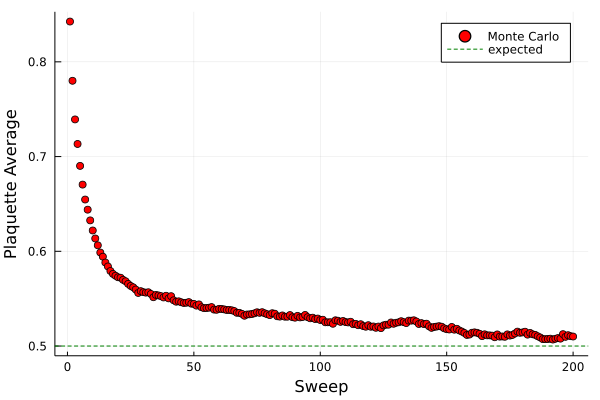

In [33]:
function test()
    a = 1.
    β = 5.5
    u0 = 0.0
    ϵ = 0.24
    lattice_dimension = 4
	side_length = 8
    matrix_dimension = 3
    number_matrices = 50
	N_cor = 50
	N_cf = 200
    N_hits = 10
    params = Params(a, β, u0, ϵ, lattice_dimension, side_length, matrix_dimension,
        number_matrices, N_cor, N_cf, N_hits)

    lattice = Lattice(lattice_dimension,matrix_dimension,side_length)

    matrices = generatematrices(matrix_dimension,number_matrices,ϵ)

    vals = zeros(N_cf)

    absΛ = length(lattice.links)

    println(measureplaquette(lattice)/(6*absΛ))

    for j in eachindex(vals)
        sweep!(lattice,matrices,params)
        vals[j] = measureplaquette(lattice)/(6*absΛ)
    end
    println(measureplaquette(lattice)/(6*absΛ))

    plot(
        1:N_cf, vals, seriestype=:scatter,color="red",
        label="Monte Carlo", xlabel="Sweep",ylabel="Plaquette Average"
    )
    hline!([0.50],label="expected",color="green",linestyle=:dash)
    
end
test()

1.0
0.5418458129605537


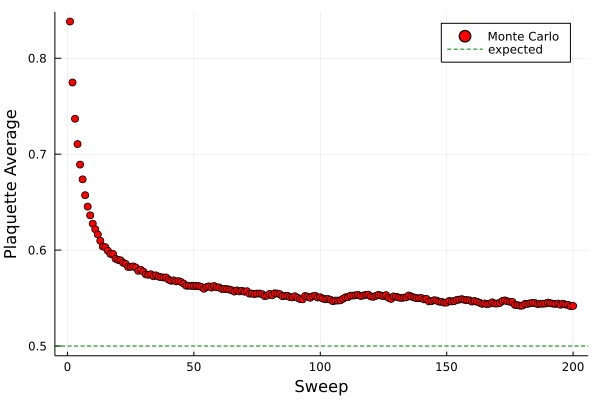

In [35]:
function test()
    a = 1.
    β = 1.719
    u0 = 0.797
    ϵ = 0.24
    lattice_dimension = 4
	side_length = 8
    matrix_dimension = 3
    number_matrices = 50
	N_cor = 50
	N_cf = 200
    N_hits = 10
    params = Params(a, β, u0, ϵ, lattice_dimension, side_length, matrix_dimension,
        number_matrices, N_cor, N_cf, N_hits)

    lattice = Lattice(lattice_dimension,matrix_dimension,side_length)

    matrices = generatematrices(matrix_dimension,number_matrices,ϵ)

    vals = zeros(N_cf)

    absΛ = length(lattice.links)

    println(measureplaquette(lattice)/(6*absΛ))

    for j in eachindex(vals)
        sweepimproved!(lattice,matrices,params)
        vals[j] = measureplaquette(lattice)/(6*absΛ)
    end
    println(measureplaquette(lattice)/(6*absΛ))

    plot(
        1:N_cf, vals, seriestype=:scatter,color="red",
        label="Monte Carlo", xlabel="Sweep",ylabel="Plaquette Average"
    )
    hline!([0.54],label="expected",color="green",linestyle=:dash)
    
end
test()

In [37]:
function test()
    a = 1.
    β = 1.719
    u0 = 0.797
    ϵ = 0.24
    lattice_dimension = 4
	side_length = 8
    matrix_dimension = 3
    number_matrices = 50
	N_cor = 50
	N_cf = 400
    N_hits = 10
    params = Params(a, β, u0, ϵ, lattice_dimension, side_length, matrix_dimension,
        number_matrices, N_cor, N_cf, N_hits)

    lattice = Lattice(lattice_dimension,matrix_dimension,side_length)

    matrices = generatematrices(matrix_dimension,number_matrices,ϵ)

    vals = zeros(N_cf)

    absΛ = length(lattice.links)

    println(measurerectangle(lattice)/(6*absΛ))

    for j in eachindex(vals)
        sweepimproved!(lattice,matrices,params)
        vals[j] = measurerectangle(lattice)/(6*absΛ)
    end
    println(measurerectangle(lattice)/(6*absΛ))

    plot(
        1:N_cf, vals, seriestype=:scatter,color="red",
        label="Monte Carlo", xlabel="Sweep",ylabel="Plaquette Average"
    )
    hline!([0.28],label="expected",color="green",linestyle=:dash)
    
end
test()

1.0
0.281236053000106


In [96]:
function test()
    a = 1.
    β = 5.5
    ϵ = 0.24
    lattice_dimension = 4
	side_length = 8
    matrix_dimension = 3
    number_matrices = 50
	N_cor = 50
	N_cf = 400
    N_hits = 10
    params = Params(a, β, ϵ, lattice_dimension, side_length, matrix_dimension,
        number_matrices, N_cor, N_cf, N_hits)

    lattice = Lattice(lattice_dimension,matrix_dimension,side_length)

    matrices = generatematrices(matrix_dimension,number_matrices,ϵ)

    vals = zeros(N_cf)

    absΛ = length(lattice.links)

    println(measureplaquette(lattice)/(6*absΛ))

    for j in eachindex(vals)
        sweep!(lattice,matrices,params)
        vals[j] = measureplaquette(lattice)/(6*absΛ)
    end
    println(measureplaquette(lattice)/(6*absΛ))

    plot(
        1:N_cf, vals, seriestype=:scatter,color="red",
        label="Monte Carlo", xlabel="Sweep",ylabel="Plaquette Average"
    )
    hline!([0.50],label="expected",color="green",linestyle=:dash)
    
end
test()

1.0
0.4955059960968955


1.0
0.2574867972911941


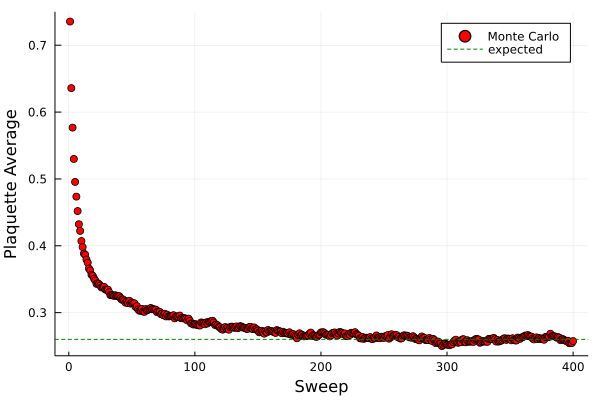

In [54]:
function test()
   a = 1.
   β = 5.5
   ϵ = 0.24
   lattice_dimension = 4
  side_length = 8
   matrix_dimension = 3
   number_matrices = 50
  N_cor = 50
  N_cf = 400
   N_hits = 10
   params = Params(a, β, ϵ, lattice_dimension, side_length, matrix_dimension,
       number_matrices, N_cor, N_cf, N_hits)

   lattice = Lattice(lattice_dimension,matrix_dimension,side_length)

   matrices = generatematrices(matrix_dimension,number_matrices,ϵ)

   vals = zeros(N_cf)

   absΛ = length(lattice.links)

   println(measurerectangle(lattice)/(6*absΛ))

   for j in eachindex(vals)
       sweep!(lattice,matrices,params)
       vals[j] = measurerectangle(lattice)/(6*absΛ)
   end
   println(measurerectangle(lattice)/(6*absΛ))

   plot(
       1:N_cf, vals, seriestype=:scatter,color="red",
       label="Monte Carlo", xlabel="Sweep",ylabel="Plaquette Average"
   )
   hline!([0.26],label="expected",color="green",linestyle=:dash)
   
end
test()

### Exercise 10

Design a computer code for evaluating gluonic path integrals using the Metroplis algorithm. Do this first for the simplest lattice action, the Wilson action (Eq. (94)):

$$ S_\text{Wil} = -\tilde{\beta}\sum_{x,\mu>\nu}\frac{P_{\mu\nu}(x)}{u_0^4}. $$

Run simulations at $\beta \coloneqq \tilde{\beta}/u_0^4 = 5.5$, which corresponds to a lattice spacing of around 0.25 fm. The lattice volume should be of order 2 fm on a side for typical QCD simulations; use $L/a = 8$ points on a side in your simulations. Set the Metropolis step size $\epsilon = 0.24$ and omit $N_\text{cor} = 50$ sweeps between Monte Carlo measurements. Computer Monte Carlo averages of $a \times a$ and $a \times 2a$ Wilson loops; you should obtain about 0.50 and 0.26, respectively. 

Also try the improved action, Eq. (103):

$$ S_\text{improv} = -\beta\sum_{x,\mu>\nu}\bigg( \frac{5}{3}\frac{P_{\mu\nu}}{u_0^4} - \frac{R_{\mu\nu}+R_{\nu\mu}}{12u_0^6} \bigg). $$

Use $\beta = 1.719$ and $u_0 = 0.797$ to again obatin $a \approx 0.25$ fm. The $a \times a$ and $a \times 2a$ Wilson loops have values of 0.54 and 0.28, respectively. (Wilson loops are unrenormalized and so these values need not agree with those from the Wilson action.)

## Solution

Having written the code, we can first compare the convergence of the improved vs. unimproved actions, both to get a sense of the improvement, and also to gauge how long to equilibrate for.

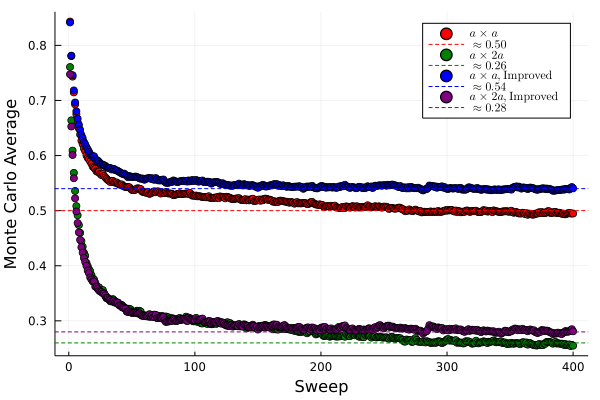

In [48]:
function equilibrating()
    a = 1.
    β = 5.5
    u0 = 0.0
    ϵ = 0.24
    lattice_dimension = 4
	side_length = 8
    matrix_dimension = 3
    number_matrices = 50
	N_cor = 50
	N_cf = 400
    N_hits = 10
    params = Params(a, β, u0, ϵ, lattice_dimension, side_length, matrix_dimension,
        number_matrices, N_cor, N_cf, N_hits)

    lattice = Lattice(lattice_dimension,matrix_dimension,side_length)

    β = 1.719
    u0 = 0.797
    paramsimproved = Params(a, β, u0, ϵ, lattice_dimension, side_length, matrix_dimension,
    number_matrices, N_cor, N_cf, N_hits)

    latticeimproved = Lattice(lattice_dimension,matrix_dimension,side_length)

    matrices = generatematrices(matrix_dimension,number_matrices,ϵ)

    avgplaqs = zeros(N_cf)
    avgrects = zeros(N_cf)
    avgplaqsimp = zeros(N_cf)
    avgrectsimp = zeros(N_cf)
    absΛ = length(lattice.links)


    for j in eachindex(avgplaqs)
        sweep!(lattice,matrices,params)
        avgplaqs[j] = measureplaquette(lattice)/(6*absΛ)
        avgrects[j] = measurerectangle(lattice)/(6*absΛ)

        sweepimproved!(latticeimproved,matrices,paramsimproved)
        avgplaqsimp[j] = measureplaquette(latticeimproved)/(6*absΛ)
        avgrectsimp[j] = measurerectangle(latticeimproved)/(6*absΛ)
    end

    plot(
        1:N_cf, avgplaqs, seriestype=:scatter,color="red",
        label=L"a\times a", xlabel="Sweep",ylabel="Monte Carlo Average"
    )
    hline!([0.50],label=L"\approx 0.50",color="red",linestyle=:dash)
    plot!(
        1:N_cf, avgrects, seriestype=:scatter,color="green",
        label=L"a\times2a"
    )
    hline!([0.26],label=L"\approx 0.26",color="green",linestyle=:dash)

    plot!(
        1:N_cf, avgplaqsimp, seriestype=:scatter,color="blue",
        label=L"a\times a,\mathrm{ Improved}"
    )
    hline!([0.54],label=L"\approx 0.54",color="blue",linestyle=:dash)
    plot!(
        1:N_cf, avgrectsimp, seriestype=:scatter,color="purple",
        label=L"a\times2a,\mathrm{ Improved}"
    )
    hline!([0.28],label=L"\approx 0.28",color="purple",linestyle=:dash)
    
end
equilibrating()

We can take about $4 * N_{cf} = 200$ sweeps to equilbrate the lattice.